<b>Load Libraries</b>

In [3]:
# data structure
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import silhouette_visualizer
## settings
%matplotlib inline
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['figure.figsize'] = (10, 6)

# model
from sklearn.cluster import KMeans

# speed up sklearn
from ray.util.joblib import register_ray
import joblib

<b>Load Dataset</b>

In [7]:
# dataset
df = pd.read_csv('../dataset/cleaned_rfm.csv').set_index('customer_id')
df_model = pd.read_csv('../dataset/processed_outliers.csv')

# dtype columns separation
num_cols = df_model.select_dtypes(np.number).columns.tolist()

<b>Model Testing</b>

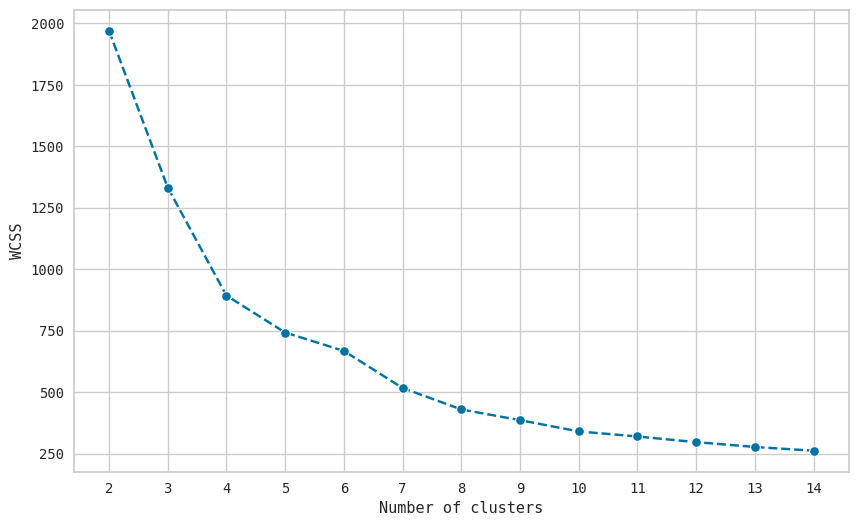

In [19]:
# The elbow method
results = []
for i in range(2, 15):
    register_ray()
    with joblib.parallel_backend('ray'):
        model = KMeans(n_clusters=i, init='k-means++', max_iter=500, random_state=7)
        model.fit(df_model[num_cols].values)
        results.append(model.inertia_)

## plotting
g = sns.lineplot(results, marker='o', linestyle='--')
g.set_xticks(range(13)); g.set_xticklabels([i for i in range(2, 15)])
g.set_xlabel('Number of clusters'); g.set_ylabel('WCSS')
plt.show()

## Conclusion: The optimal number of clusters may be in range from 5 to 7

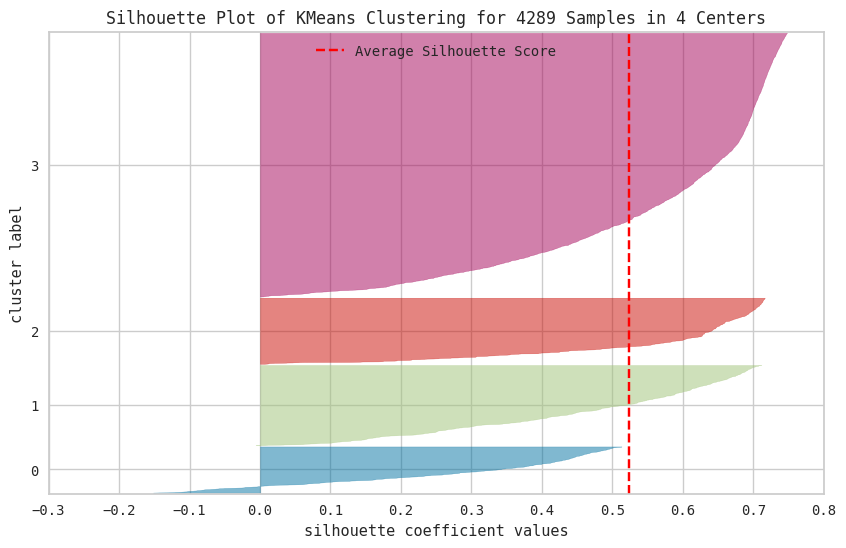

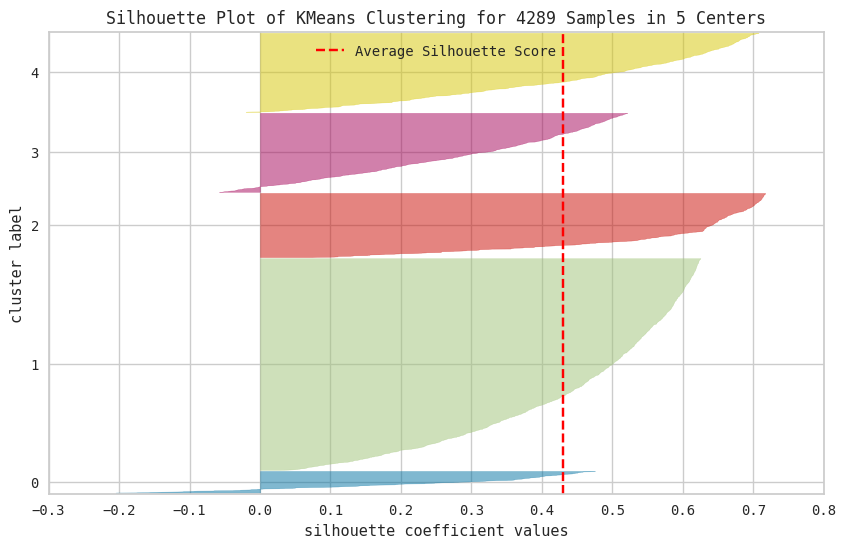

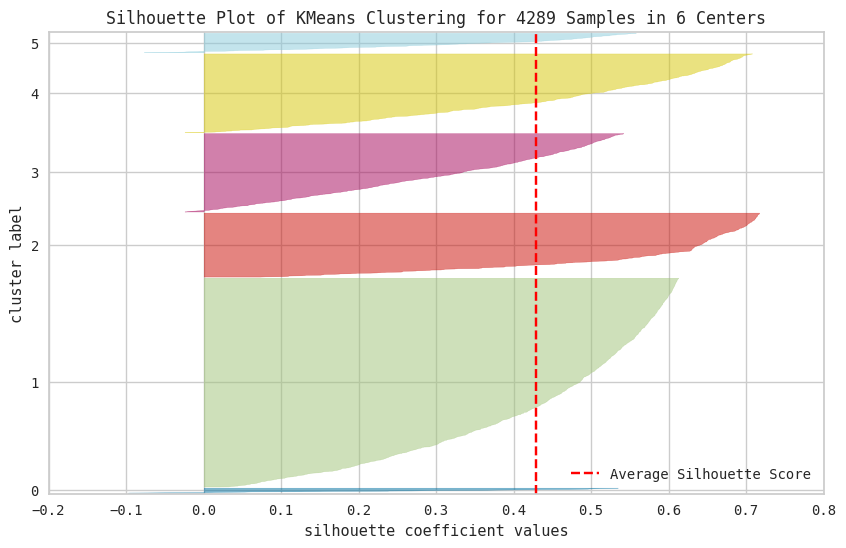

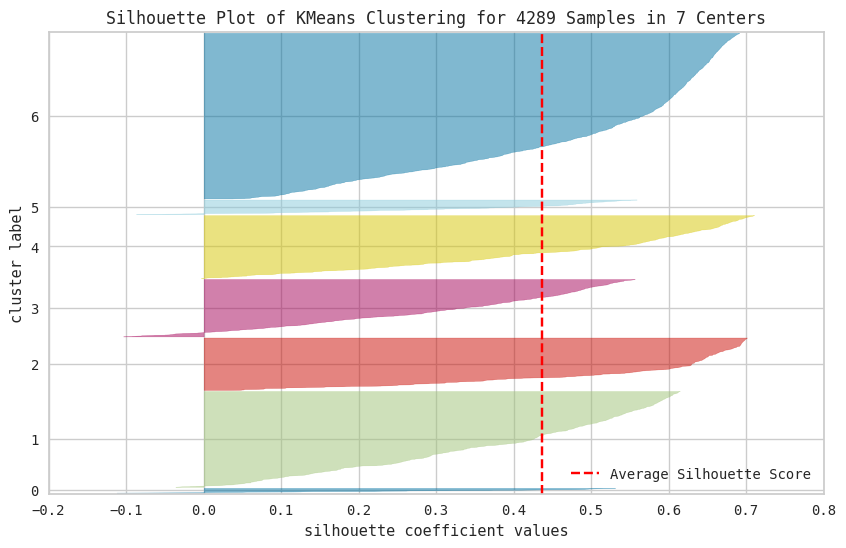

In [10]:
# silhouette
for i in [4, 5, 6, 7]:
    silhouette_visualizer(KMeans(n_clusters=i, init='k-means++', max_iter=500, random_state=7), df_model[num_cols].values, colors='yellowbrick')
    plt.show()

<b>Finalize Model</b>

In [14]:
# finalize model
model = KMeans(n_clusters=4, init='k-means++', max_iter=500, random_state=7)
labels = model.fit_predict(df_model[num_cols].values)
df['label'] = labels

## save the model
joblib.dump(model, '../models/4Clusters_model.pkl')

['../models/4Clusters_model.pkl']

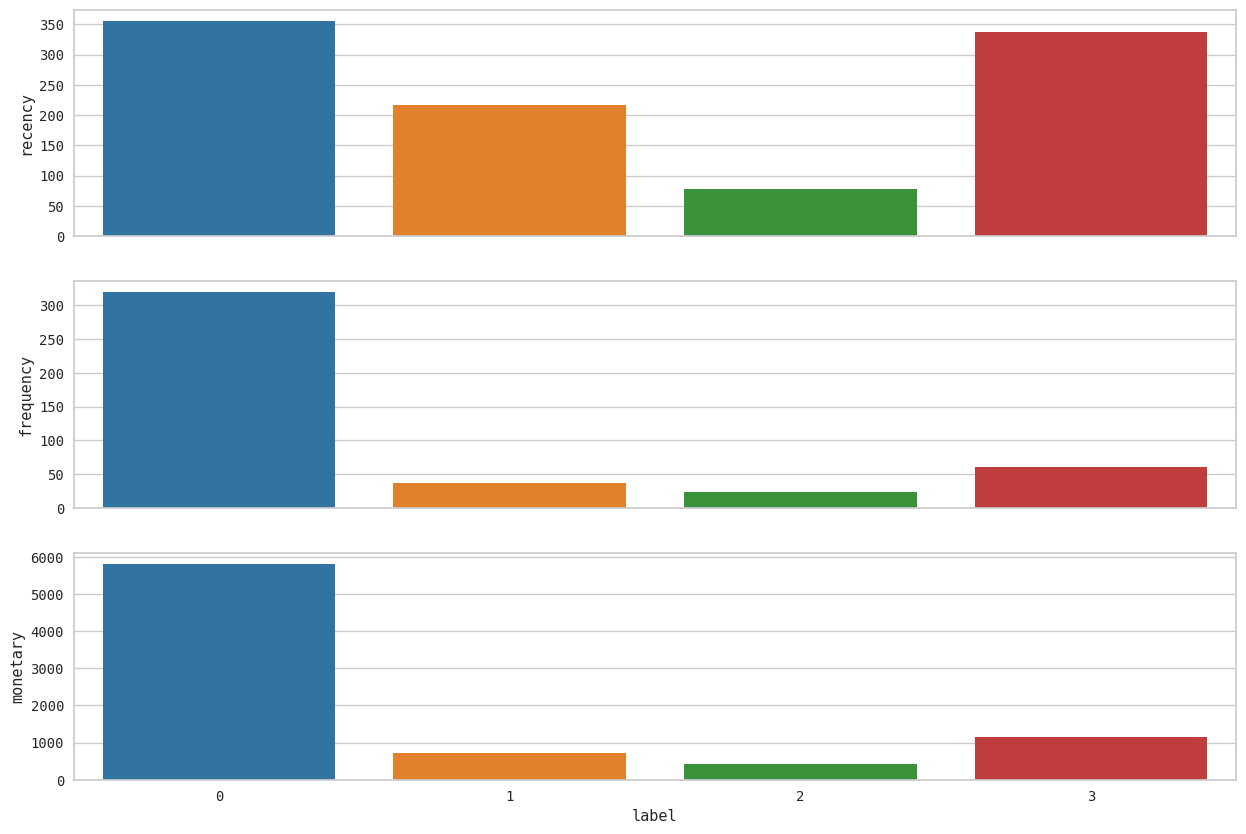

In [16]:
# plotting results
fig, axes = plt.subplots(3, 1, sharex=True)
fig.set_figwidth(15); fig.set_figheight(10)

res = df.groupby('label', observed=True)[num_cols].mean()
for i, name in enumerate(num_cols):
    g = sns.barplot(data=res, x='label', y=name, hue='label', legend=False, palette='tab10', ax=axes[i])

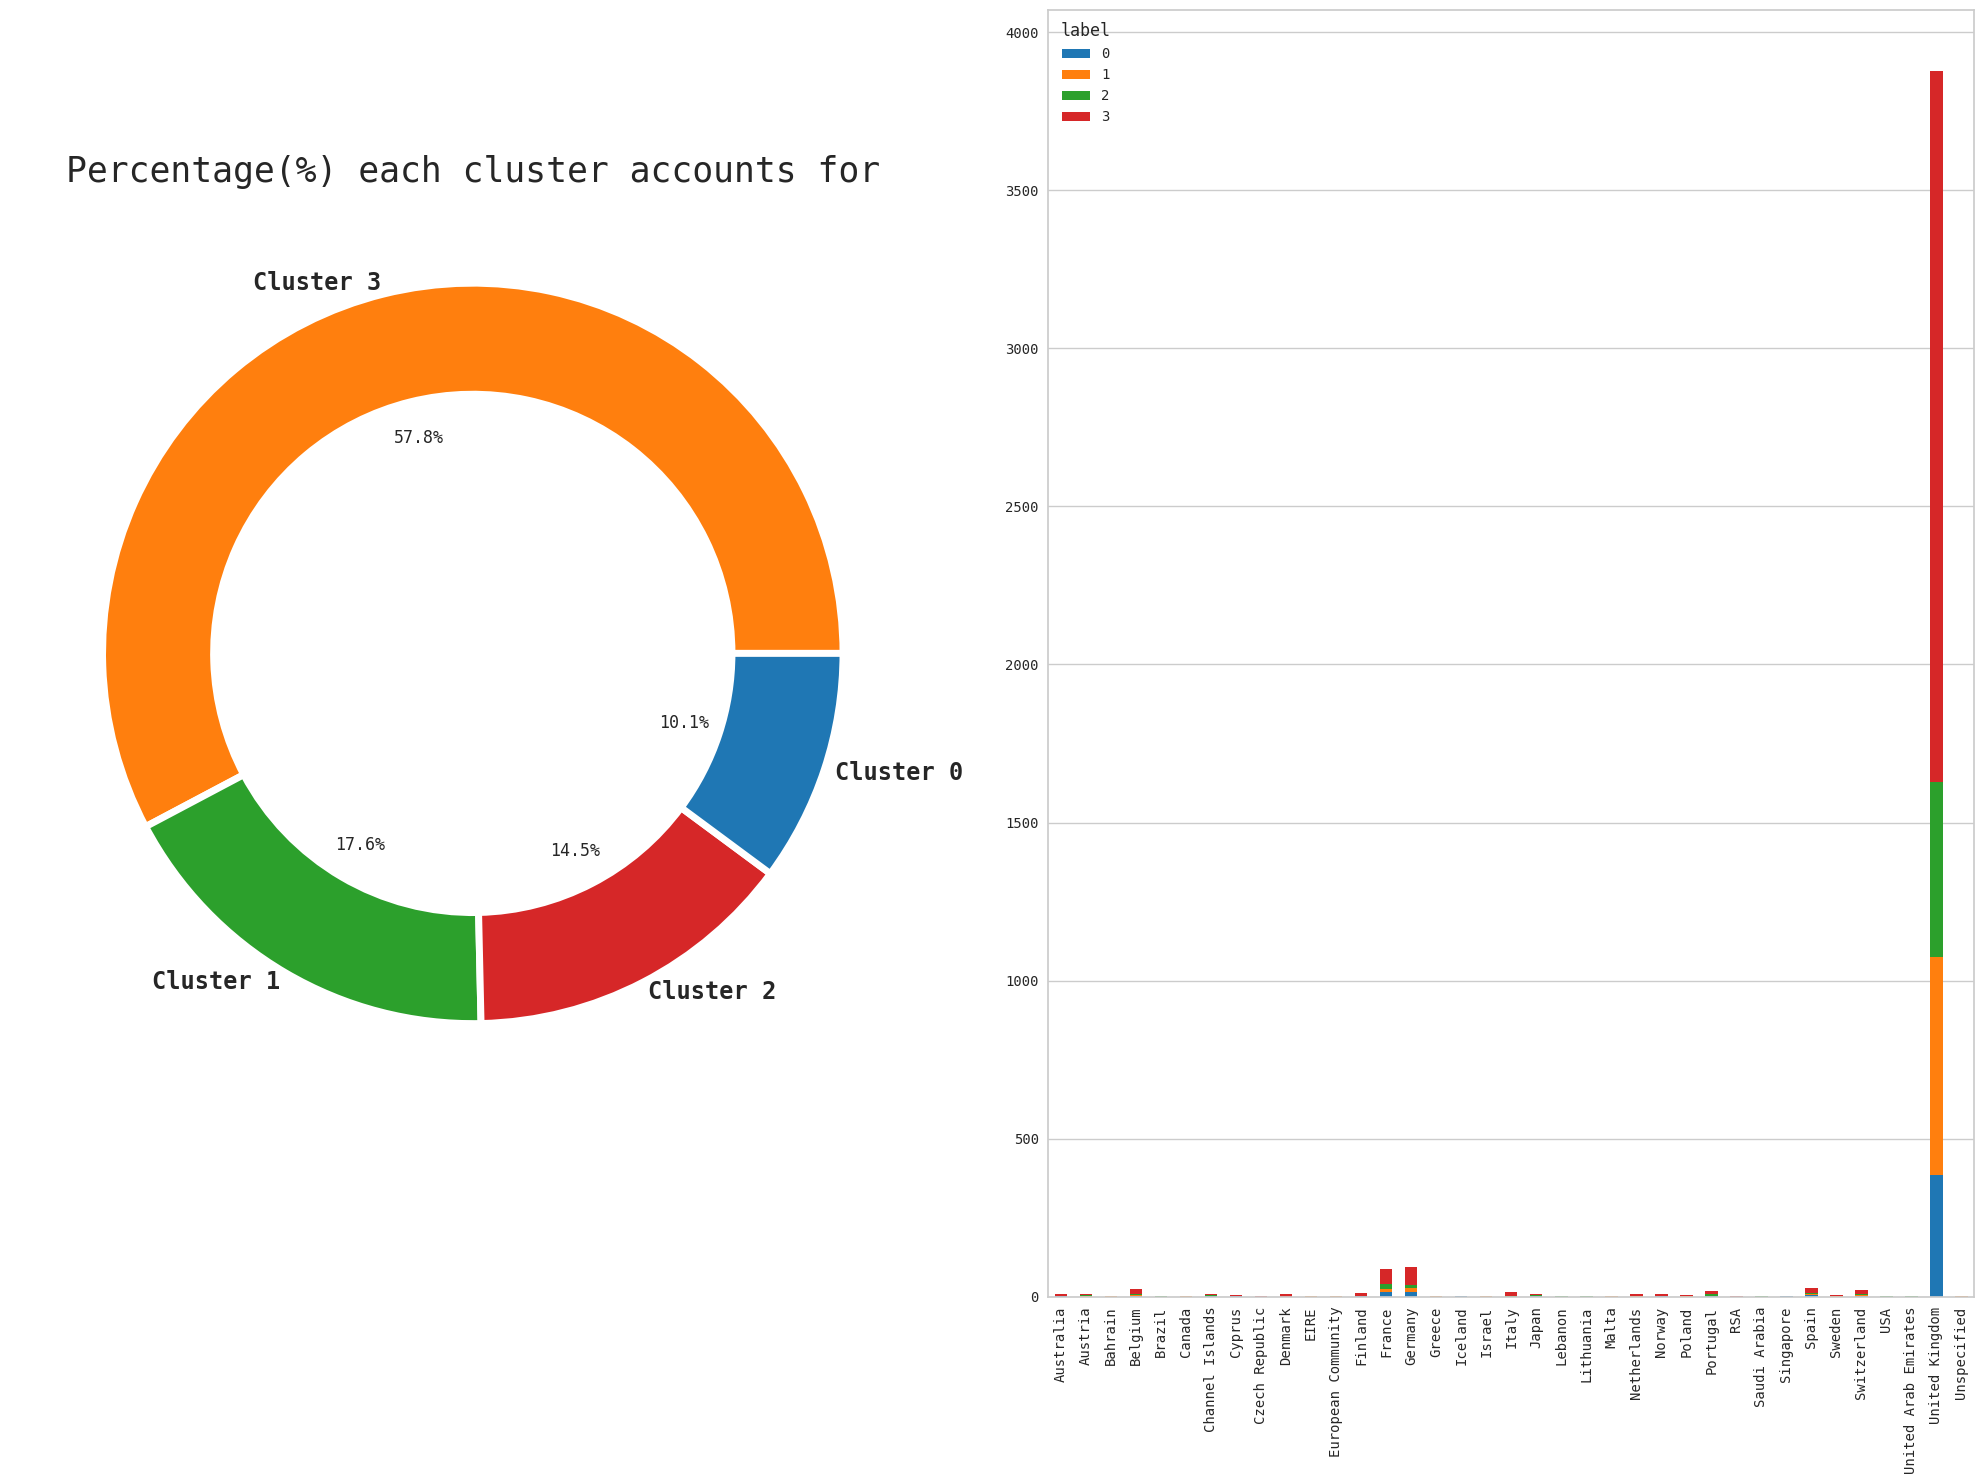

In [18]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(20); fig.set_figheight(15)

# pie plot
##
x = df['label'].value_counts().sort_values(ascending=False)
##
wedges, labels, autopct = axes[0].pie(x.values, labels=[f'Cluster {i}' for i in x.index.tolist()], 
            labeldistance=1.03, autopct='%1.1f%%',
            wedgeprops=dict(width=0.3, linewidth=5, edgecolor='white'), 
            colors=['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4'])
##
axes[0].set_title('Percentage(%) each cluster accounts for', fontsize=25)
## 
for label in labels:
    label.set_fontsize(17)
    label.set_weight('bold')


# bar
g = pd.crosstab(df['country'], df['label']).plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], legend=True, ax=axes[1])
g.set_xlabel(None)
g.grid(axis='x')

plt.tight_layout()
plt.show()

## Conclusion: Most of all clusters are in 'United Kingdom'